# Проект: Определение перспективного тарифа для телеком компании

## Описание проекта

В проекте имеем пять таблиц с данными за 2018г.: 
- количество и продолжиьельность телефонных звонков, 
- количество смс, 
- количество интернет трафика, 
- данные о пользователях сотовой сети
- данные о трифах Smart и Ultra. 

Сотовый оператор предлагает клиентам два тарифных плана: «Смарт» и «Ультра». 
Коммерческому департаменту нужно скорректировать рекламный бюджет, и нужно понять, какой тариф приносит больше денег.

Проанализируем тарифы и поведение клиентов и сделаем вывод — какой тариф лучше.

###  Исследование разделим на несколько частей:

1. [Изученеие файлов с данными, получение общей информации, загрузка библиотек](#stepone)

2. [Предобработка данных](#steptwo)

3. [Анализ данных](#stepthree)

4. [Проверка гипотез](#stepfour)

5. [Выводы](#stepfive)

## Шаг 1. Выгрузка данных и изучение общей информации<a id="stepone"></a>   </div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from math import factorial
from scipy import stats as st

calls_df = pd.read_csv('calls.csv')
internet_df = pd.read_csv('internet.csv')
messages_df = pd.read_csv('messages.csv')
tariffs_df = pd.read_csv('tariffs.csv')
polz_df = pd.read_csv("users.csv")
# calls_df.head()
# internet_df.head()
# messages_df.head()
# tariffs_df.head()
# polz_df.head()

#### Вывод

Открылись таблички. На первый взгляд всё читается. Столбцов мало, информация доступна. Переформатируем даты и выделим столбец с месяцем. Будет нужен для расчётов.

In [2]:
# отформатируем даты
# список таблиц в которых меняем datetime
date_df = [calls_df, internet_df, messages_df, tariffs_df, polz_df]
 
#функция меняет на datetime
def datetime_format (df):
    for column in df.columns:
        if 'date' in column:
            df[column] = pd.to_datetime(df[column], format = '%Y-%m-%d')
    return df

    
for dataframe in date_df:
    dataframe = datetime_format(dataframe)

In [3]:
# добавим столбец с месяцем отдельно

date_df = [calls_df, internet_df, messages_df, tariffs_df, polz_df]
 
#функция меняет на datetime
def month_column (df):
    for column in df.columns:
        if 'date' in column:
            df['month'] = df[column].dt.month
    return df

    
for dataframe in date_df:
    dataframe = month_column(dataframe)

In [4]:
# округлим в большую сторону, как это делает провайдер
calls_df = calls_df.query('duration >= 1').copy()
calls_df['duration'] = np.ceil(calls_df.duration)
calls_df.info()
calls_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154680 entries, 2 to 202606
Data columns (total 5 columns):
id           154680 non-null object
call_date    154680 non-null datetime64[ns]
duration     154680 non-null float64
user_id      154680 non-null int64
month        154680 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 7.1+ MB


,id,call_date,duration,user_id,month
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12
7,1000_7,2018-08-22,19.0,1000,8
8,1000_8,2018-09-15,19.0,1000,9


In [5]:
# округлим в большую сторону, как это делает провайдер
callsinternet_df = internet_df.query('mb_used > 0').copy()
internet_df['mb_used'] = np.ceil(internet_df.mb_used)
internet_df.info()
internet_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 6 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
month           149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 6.8+ MB


,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,1000_0,113.0,2018-11-25,1000,11
1,1,1000_1,1053.0,2018-09-07,1000,9
2,2,1000_2,1198.0,2018-06-25,1000,6
3,3,1000_3,551.0,2018-08-22,1000,8
4,4,1000_4,303.0,2018-09-24,1000,9


In [6]:
messages_df.info()
messages_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
month           123036 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.8+ MB


,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [7]:
tariffs_df.info()
tariffs_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [8]:
polz_df.info()
polz_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
month         500 non-null int64
dtypes: datetime64[ns](2), int64(3), object(4)
memory usage: 35.3+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,11
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,8
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,5


#### Вывод

Добавил столбец с месяцем во все таблички, проверил данные. Пропусков мало, в ключевых моментах пропуско нет.
Посмотрим выбросы.
Таблицы нужно объеденить.

## Шаг 2. Предобработка данных<a id="steptwo"></a>   </div>

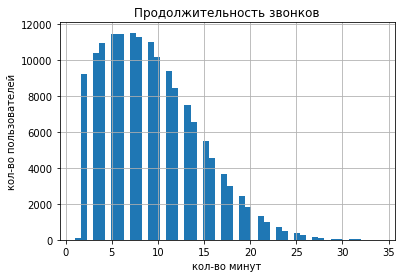

In [9]:
# Приведём данные к нужным типам;

calls_df.query('duration > 0and duration < 35')['duration'].hist(bins=50)
plt.title('Продолжительность звонков')
plt.xlabel('кол-во минут')
plt.ylabel('кол-во пользователей')
plt.show()

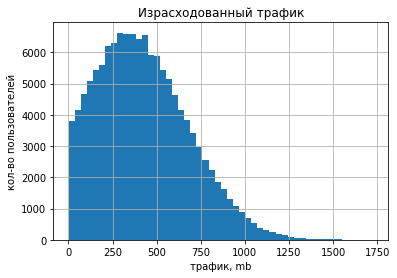

In [10]:
internet_df.query('mb_used > 0')['mb_used'].hist(bins=50)
plt.title('Израсходованный трафик')
plt.xlabel('трафик, mb')
plt.ylabel('кол-во пользователей')
plt.show()

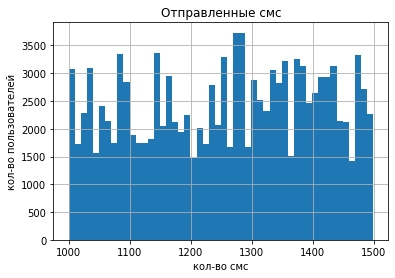

In [11]:
messages_df['user_id'].hist(bins=50)
plt.title('Отправленные смс')
plt.xlabel('кол-во смс')
plt.ylabel('кол-во пользователей')
plt.show()

#### Вывод

Много нулевых значений. Пользователи не отвечают на звонок, не пользуются интернетом, не отправляют смс. Такие ситуации бывают. На гистограмме смс видим как часто пользователи отправляют сообщения. Гистограммы звонков и трафика имеют вид распределения Пуассона

## Посчитайте для каждого пользователя:

In [12]:
# количество сделанных звонков, кол-во израсходованных минут разговора по месяцам
calls_pivot = calls_df.query('duration > 0').pivot_table(
    index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum']).reset_index()
calls_pivot.columns = ['user_id', 'month', 'count_calls', 'sum_calls_duration']
calls_pivot.head()

,user_id,month,count_calls,sum_calls_duration
0,1000,5,16,158.0
1,1000,6,27,171.0
2,1000,7,39,338.0
3,1000,8,41,407.0
4,1000,9,43,463.0


In [13]:
# объем израсходованного интернет-трафика по месяцам;
internet_pivot = internet_df.query('mb_used > 0').pivot_table(
    index=['user_id', 'month'], values='mb_used', aggfunc=['count', 'sum']).reset_index()
internet_pivot.columns = ['user_id', 'month', 'count_sessions', 'sum_mb_used']
internet_pivot.head()

,user_id,month,count_sessions,sum_mb_used
0,1000,5,4,2256.0
1,1000,6,44,23257.0
2,1000,7,28,14016.0
3,1000,8,27,14070.0
4,1000,9,25,14581.0


In [14]:
# количество отправленных сообщений по месяцам;
messages_pivot = messages_df.pivot_table(index=['user_id', 'month'], values='id', aggfunc=['count']).reset_index()
messages_pivot.columns = ['user_id', 'month', 'count_mess']
messages_pivot.head()

,user_id,month,count_mess
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [15]:
# сведём в одну таблицу
calls_mess_merged_df = calls_pivot.merge(messages_pivot , on=['user_id', 'month'], how='outer')
calls_mess_merged_df.head()

calls_mess_int_merged_df = calls_mess_merged_df.merge(internet_pivot , on=['user_id', 'month'], how='outer')
calls_mess_int_merged_df.head()

#total_df = calls_mess_int_merged_df.merge(polz_df, on=['user_id'], how='left')
total_df = calls_mess_int_merged_df.merge(polz_df[['user_id', 'tariff', 'city']], how = 'left', on = 'user_id') 

total_df['sum_gb_used'] = (total_df['sum_mb_used'] / 1024)
total_df['sum_gb_used'] = np.ceil(total_df.sum_gb_used)

total_df = total_df.fillna(0)
total_df.info()
total_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 10 columns):
user_id               3214 non-null int64
month                 3214 non-null int64
count_calls           3214 non-null float64
sum_calls_duration    3214 non-null float64
count_mess            3214 non-null float64
count_sessions        3214 non-null float64
sum_mb_used           3214 non-null float64
tariff                3214 non-null object
city                  3214 non-null object
sum_gb_used           3214 non-null float64
dtypes: float64(6), int64(2), object(2)
memory usage: 276.2+ KB


,user_id,month,count_calls,sum_calls_duration,count_mess,count_sessions,sum_mb_used,tariff,city,sum_gb_used
0,1000,5,16.0,158.0,22.0,4.0,2256.0,ultra,Краснодар,3.0
1,1000,6,27.0,171.0,60.0,44.0,23257.0,ultra,Краснодар,23.0
2,1000,7,39.0,338.0,75.0,28.0,14016.0,ultra,Краснодар,14.0
3,1000,8,41.0,407.0,81.0,27.0,14070.0,ultra,Краснодар,14.0
4,1000,9,43.0,463.0,57.0,25.0,14581.0,ultra,Краснодар,15.0


#### Вывод

Свел все таблицы в одну total_df. Ввел столбец с гигабайтами, округлил в большую сторону. Переименовал столбцы. Наконец получили сводную таблицу с которой можно работать. Видим активности пользователей по месяцам, город и тариф. 

In [16]:
tariffs_df.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


#### Посчитаем для каждого пользователя помесячную выручку с каждого пользователя

- вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика;
- остаток умножим на значение из тарифного плана;
- прибавим абонентскую плату, соответствующую тарифному плану

In [17]:
print('Считаем для тарифа smart')
total_df_grouped = total_df.groupby(
    ['tariff', 'month', 'user_id', 'city'])['sum_calls_duration', 'count_mess', 'sum_gb_used'].sum()
total_df_grouped.head()
smart_total_df_grouped = total_df_grouped.query('tariff == "smart"').reset_index().copy()
smart_total_df_grouped['min_incl'] = 500
smart_total_df_grouped['mess_incl'] = 50
smart_total_df_grouped['gb_per_month_incl'] = 15360/1024
smart_total_df_grouped['min_used_rub'] = (smart_total_df_grouped['sum_calls_duration']-smart_total_df_grouped['min_incl'])*3+550
smart_total_df_grouped['mess_used_rub'] = (smart_total_df_grouped['count_mess']-smart_total_df_grouped['mess_incl'])*3+550
smart_total_df_grouped['gb_used_rub'] = (
    smart_total_df_grouped['sum_gb_used']-smart_total_df_grouped['gb_per_month_incl'])*200+550

Считаем для тарифа smart


In [18]:
smart_total_df_grouped.head()

,tariff,month,user_id,city,sum_calls_duration,count_mess,sum_gb_used,min_incl,mess_incl,gb_per_month_incl,min_used_rub,mess_used_rub,gb_used_rub
0,smart,1,1005,Набережные Челны,94.0,7.0,3.0,500,50,15.0,-668.0,421.0,-1850.0
1,smart,1,1032,Ульяновск,378.0,38.0,24.0,500,50,15.0,184.0,514.0,2350.0
2,smart,1,1045,Улан-Удэ,9.0,5.0,3.0,500,50,15.0,-923.0,415.0,-1850.0
3,smart,1,1055,Казань,550.0,30.0,17.0,500,50,15.0,700.0,490.0,950.0
4,smart,1,1071,Омск,194.0,16.0,16.0,500,50,15.0,-368.0,448.0,750.0


In [19]:
smart_total_df_grouped.shape

(2229, 13)

In [20]:
print('Считаем для тарифа ultra')
ultra_total_df_grouped = total_df_grouped.query('tariff == "ultra"').reset_index().copy()

ultra_total_df_grouped['min_incl'] = 3000
ultra_total_df_grouped['mess_incl'] = 1000
ultra_total_df_grouped['gb_per_month_incl'] = 30720/1024

ultra_total_df_grouped['min_used_rub'] = (
    ultra_total_df_grouped['sum_calls_duration']-ultra_total_df_grouped['min_incl'])*1+1950
ultra_total_df_grouped['mess_used_rub'] = (ultra_total_df_grouped['count_mess']-ultra_total_df_grouped['mess_incl'])*1+1950
ultra_total_df_grouped['gb_used_rub'] = (
    ultra_total_df_grouped['sum_gb_used']-ultra_total_df_grouped['gb_per_month_incl'])*150+1950

Считаем для тарифа ultra


In [21]:
ultra_total_df_grouped.head()

,tariff,month,user_id,city,sum_calls_duration,count_mess,sum_gb_used,min_incl,mess_incl,gb_per_month_incl,min_used_rub,mess_used_rub,gb_used_rub
0,ultra,1,1120,Краснодар,55.0,0.0,1.0,3000,1000,30.0,-995.0,950.0,-2400.0
1,ultra,1,1126,Санкт-Петербург,272.0,4.0,16.0,3000,1000,30.0,-778.0,954.0,-150.0
2,ultra,1,1168,Кострома,274.0,14.0,8.0,3000,1000,30.0,-776.0,964.0,-1350.0
3,ultra,1,1254,Москва,465.0,0.0,20.0,3000,1000,30.0,-585.0,950.0,450.0
4,ultra,1,1375,Пенза,846.0,75.0,15.0,3000,1000,30.0,-204.0,1025.0,-300.0


In [22]:
ultra_total_df_grouped.shape

(985, 13)

#### Вывод

Сгруппировал общую таблицу по тарифам. Тарифом Смарт пользуются практически в два раза больше людей чем Ультрой. Видимо отпугивает месячная абонплата в 1950. Это очень интересно, если посмотреть на графики ниже.

## Шаг 3. Анализ данных<a id="stepthree"></a>   </div>

Посмотрим на поведение клиентов оператора, исходя из выборки. 

Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 

### Считаем среднее количество, дисперсию и стандартное отклонение.

In [23]:
#считаем среднее по тарифу smart
pd.options.display.float_format = '{:.2f}'.format
mean_smart_df = smart_total_df_grouped.groupby('month')['sum_calls_duration', 'count_mess', 'sum_gb_used'].mean()
print('Средняя продолжительность звонков. Смарт', mean_smart_df['sum_calls_duration'].mean())
print('Среднее кол-во сообщений. Смарт', mean_smart_df['count_mess'].mean())
print('Средняя кол-во gb. Смарт', mean_smart_df['sum_gb_used'].mean())
mean_smart_df   

Средняя продолжительность звонков. Смарт 384.5502952244915
Среднее кол-во сообщений. Смарт 31.413210661085547
Средняя кол-во gb. Смарт 15.223806019421163


,sum_calls_duration,count_mess,sum_gb_used
month,,,
1,202.85,18.24,8.74
2,297.22,24.09,11.84
3,387.77,31.86,15.25
4,365.03,30.74,13.64
5,384.84,33.77,15.94
6,393.35,33.40,15.98
7,405.97,33.75,15.91
8,419.01,33.64,16.78
9,426.29,33.64,16.42


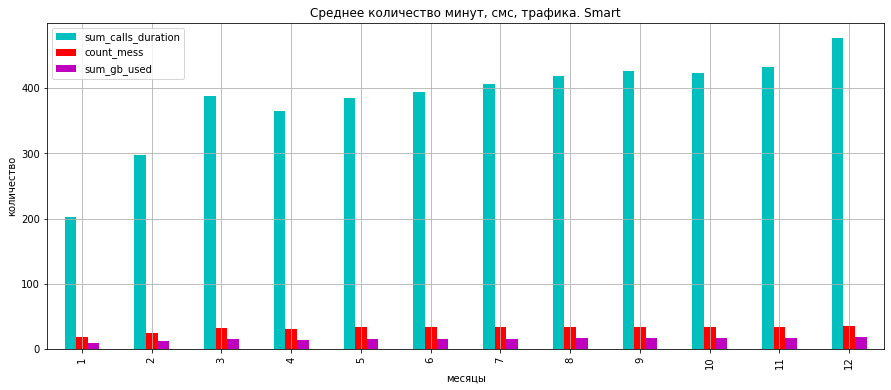

In [24]:
mean_smart_df.plot(kind='bar', grid=True, figsize = (15,6), color=['c', 'r', 'm'])
plt.title('Среднее количество минут, смс, трафика. Smart')
plt.xlabel('месяцы')
plt.ylabel('количество')
plt.show()

In [25]:
# считаем дисперсию по выборке smart, минуты разговора, сообщения, интернет

variance_estimate_calls_dur = np.var(smart_total_df_grouped['sum_calls_duration'], ddof=1)
variance_estimate_count_mess = np.var(smart_total_df_grouped['count_mess'], ddof=1)
variance_estimate_sum_gb_used = np.var(smart_total_df_grouped['sum_gb_used'], ddof=1)


print('Дисперсия по выборке smart, минуты разговора:', variance_estimate_calls_dur)
print('Дисперсия по выборке smart, смс:', variance_estimate_count_mess)
print('Дисперсия по выборке smart, интернет:', variance_estimate_sum_gb_used)

Дисперсия по выборке smart, минуты разговора: 35847.35040066755
Дисперсия по выборке smart, смс: 796.8129584480083
Дисперсия по выборке smart, интернет: 33.16030407078876


In [26]:
# стандартное отклонение по выборке smart, минуты разговора, сообщения, интернет

standard_deviation_calls_dur = np.std(smart_total_df_grouped['sum_calls_duration'], ddof=1)
standard_deviation_count_mess = np.std(smart_total_df_grouped['count_mess'], ddof=1)
standard_deviation_sum_gb_used = np.std(smart_total_df_grouped['sum_gb_used'], ddof=1)

print('Стандартное отклонение по выборке smart, минуты разговора:', standard_deviation_calls_dur)
print('Стандартное отклонение по выборке smart, смс:', standard_deviation_count_mess)
print('Стандартное отклонение по выборке smart, интернет:', standard_deviation_sum_gb_used)

Стандартное отклонение по выборке smart, минуты разговора: 189.33396525892428
Стандартное отклонение по выборке smart, смс: 28.22787555676141
Стандартное отклонение по выборке smart, интернет: 5.7584984215321935


In [27]:
#считаем среднее по тарифу ultra
pd.options.display.float_format = '{:.2f}'.format
mean_ultra_df = ultra_total_df_grouped.groupby('month')['sum_calls_duration', 'count_mess', 'sum_gb_used'].mean()
print('Средняя продолжительность звонков. Ультра', mean_ultra_df['sum_calls_duration'].mean())
print('Среднее кол-во сообщений. Ультра', mean_ultra_df['count_mess'].mean())
print('Средняя кол-во gb. Ультра', mean_ultra_df['sum_gb_used'].mean())
mean_ultra_df

Средняя продолжительность звонков. Ультра 493.1539558972259
Среднее кол-во сообщений. Ультра 43.71498284147191
Средняя кол-во gb. Ультра 18.296772400545716


,sum_calls_duration,count_mess,sum_gb_used
month,,,
1,426.33,33.78,13.33
2,295.25,21.96,12.00
3,487.14,32.30,17.70
4,455.09,31.56,17.00
5,507.27,37.85,19.43
6,477.06,41.73,18.96
7,542.89,49.85,20.54
8,508.05,48.44,19.64
9,536.67,52.29,19.25


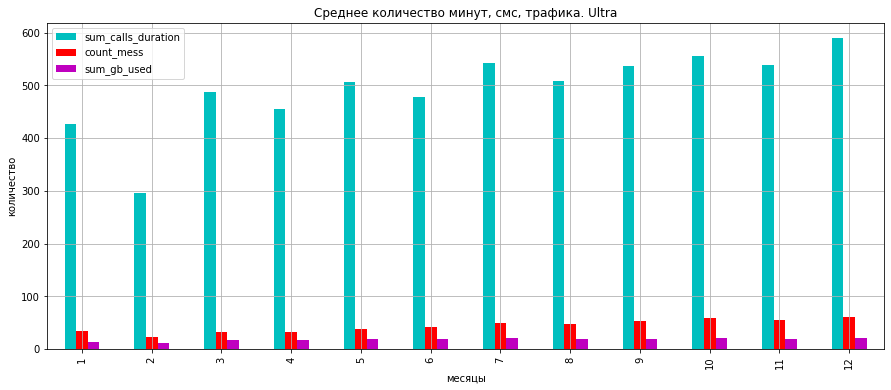

In [28]:
mean_ultra_df.plot(kind='bar', grid=True, figsize = (15,6), color=['c', 'r', 'm'])
plt.title('Среднее количество минут, смс, трафика. Ultra')
plt.xlabel('месяцы')
plt.ylabel('количество')
plt.show()

In [29]:
# считаем дисперсию по выборке ultra, минуты разговора, сообщения, интернет

variance_estimate_calls_dur = np.var(ultra_total_df_grouped['sum_calls_duration'], ddof=1)
variance_estimate_count_mess = np.var(ultra_total_df_grouped['count_mess'], ddof=1)
variance_estimate_sum_gb_used = np.var(ultra_total_df_grouped['sum_gb_used'], ddof=1)

print('Дисперсия по выборке ultra, минуты разговора:', variance_estimate_calls_dur)
print('Дисперсия по выборке ultra, смс:', variance_estimate_count_mess)
print('Дисперсия по выборке ultra, интернет:', variance_estimate_sum_gb_used)

Дисперсия по выборке ultra, минуты разговора: 99756.60867896497
Дисперсия по выборке ultra, смс: 2285.266142544674
Дисперсия по выборке ultra, интернет: 97.33494903223144


In [30]:
# стандартное отклонение по выборке ultra, минуты разговора, сообщения, интернет
standard_deviation_calls_dur = np.std(ultra_total_df_grouped['sum_calls_duration'], ddof=1)
standard_deviation_count_mess = np.std(ultra_total_df_grouped['count_mess'], ddof=1)
standard_deviation_sum_gb_used = np.std(ultra_total_df_grouped['sum_gb_used'], ddof=1)

print('Стандартное отклонение по выборке ultra, минуты разговора:', standard_deviation_calls_dur)
print('Стандартное отклонение по выборке ultra, смс:', standard_deviation_count_mess)
print('Стандартное отклонение по выборке ultra, интернет:', standard_deviation_sum_gb_used)

Стандартное отклонение по выборке ultra, минуты разговора: 315.84269609880954
Стандартное отклонение по выборке ultra, смс: 47.80445735017472
Стандартное отклонение по выборке ultra, интернет: 9.865847608403012


### Построим гистограммы

In [31]:
tariffs_df.head() # для наглядности

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


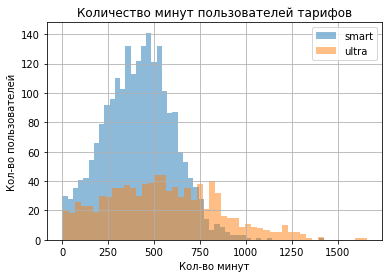

In [32]:
ax = smart_total_df_grouped.query('sum_calls_duration > 0')['sum_calls_duration'].hist(bins=50, alpha=0.5, label = 'smart')
ultra_total_df_grouped.query('sum_calls_duration > 0')['sum_calls_duration'].hist(bins=50, alpha=0.5, label = 'ultra')

plt.title('Количество минут пользователей тарифов') 
ax.set_ylabel('Кол-во пользователей')
ax.set_xlabel('Кол-во минут')
ax.legend()
plt.show()

#### Вывод

Пользователей тарифа Smart больше, но разговаривают по телефону они меньше чем пользователи тарифа Ultra. На графике видно, что на Смарте чаще перерасходуют лимит включённых минут, в то время как на Ультре 3000 минут более чем для разговоров. возможно стоит сократить лимит до 1000 минут. Пользователи не выбирают и половины этого времени. Если перемножить перерасход минут на Смарте - примерно 400-500 минут - и стоимость перерасходованной минуты, то получается пользователи Смарта платят иногда столько же сколько и пользователи Ультры. 

In [33]:
tariffs_df.head() # для наглядности

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


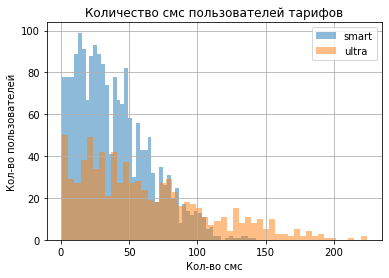

In [34]:
ax = smart_total_df_grouped.query(
    'count_mess > 0')['count_mess'].hist(bins=50, alpha=0.5, label = 'smart') # удалим немного выбросов
ultra_total_df_grouped.query('count_mess != 0')['count_mess'].hist(bins=50, alpha=0.5, label = 'ultra')

plt.title('Количество смс пользователей тарифов') 
ax.set_ylabel('Кол-во пользователей')
ax.set_xlabel('Кол-во смс')
ax.legend()
plt.show()

#### Вывод

Похожая картина и сообщениями. Пользователи Смарта уходят далеко за пределы лимита 50 сообщений в месяц (отпраляют до 100), в то время как на Ультре 1000 сообщений никому не нужны, едва выходят за границы 150. Возможно стоит сократить лимит до 100, и получать чуть больше выручки.

In [35]:
tariffs_df.head() # для наглядности

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


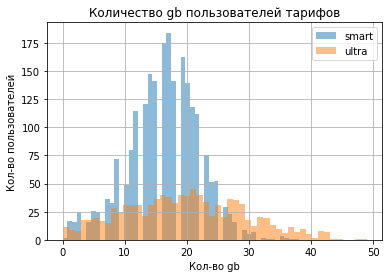

In [36]:
ax = smart_total_df_grouped['sum_gb_used'].hist(bins=50, alpha=0.5, label = 'smart')
ultra_total_df_grouped['sum_gb_used'].hist(bins=50, alpha=0.5, label = 'ultra')

plt.title('Количество gb пользователей тарифов') 
ax.set_ylabel('Кол-во пользователей')
ax.set_xlabel('Кол-во gb')
ax.legend()
plt.show()

#### Вывод

Видно что пользователям Ультры больше нравится пользоваться интернетом. Лимит практически всегда выбирается полностью, но реже превышается. На Смарте охотно пользуются интернетом и превышают лимит легко почти в два раза. 

### Описание распределений

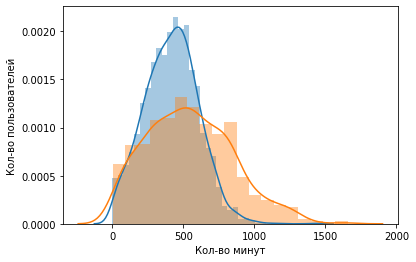

In [37]:
ax = sns.distplot(smart_total_df_grouped.query('sum_calls_duration > 0')['sum_calls_duration'])
sns.distplot(ultra_total_df_grouped.query('sum_calls_duration > 0')['sum_calls_duration'])
ax.set_ylabel('Кол-во пользователей')
ax.set_xlabel('Кол-во минут')
plt.show()

#### Вывод

Очень похожая картина и на графике плотностей. Попробуем автоматизировать построение графиков.

In [38]:
tariffs_df.head() # для наглядности

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


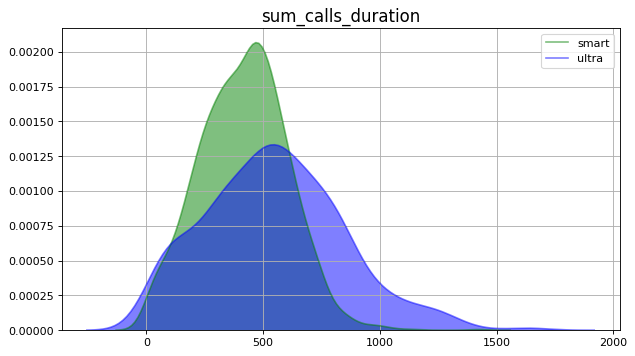

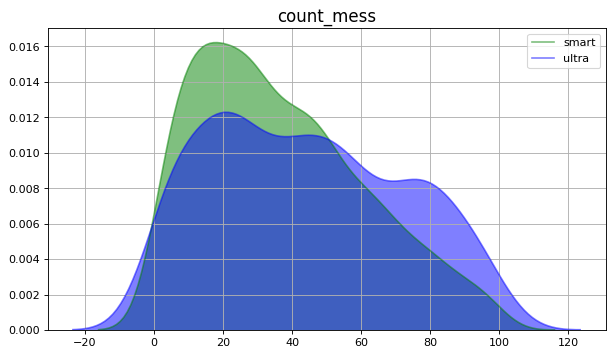

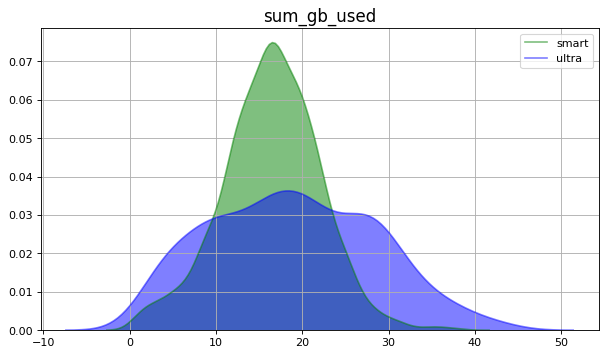

In [39]:
# построим графики плотности распределения
colors = ['green', 'blue']
target_col = ['sum_calls_duration', 'count_mess', 'sum_gb_used']

for column in target_col:
    # шаблон графика
    plt.figure(figsize=(9, 5), dpi=80)
    plt.grid()
    plt.title(column, fontsize=15)
    j=0 # итератор по цвету
    for column_value, column_slice in total_df.query(
        'sum_calls_duration > 0 and count_mess > 0 and count_mess < 100 and sum_gb_used > 0').groupby('tariff'):
        # строим график плотности распределения
        sns.kdeplot(column_slice[column], shade=True, color=colors[j], label=column_value, alpha=0.5)
        j += 1 # переключаем цвет

#### Вывод

На графиках плотностей видна схожая картина что и на гистограммах выше.
Сообщениями пользователи тарифов пользуются практически одинаково, при том, что на Ультре включено в тариф гораздо больше. 1000 сообщений. Можно не звонить вообще, а только смсится. Но эта услуга нынче не так востребована, как интернет. Перерасход трафика на обоих тарифак.

Судя по колоколообразным графиками - распределения тяготеют к нормальным, а значит можем использовать t-test.

## Шаг 4. Проверка гипотез:<a id="stepfour"></a>   </div>

- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;

- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

Пороговое значение alpha задаём самостоятельно.

#### Сформулируем гипотезы для первого утверждения. 
H-нулевая всегда формулируется так, чтобы использовать знак равенства.
- H0: средняя выручка с пользователей тарифа Smart равна средней выручке Ultra
- H1: средняя выручка с пользователей тарифа Smart не равна средней выручки Ultra

Подготовим данные

In [40]:
# все выручки каждого пользователя по тарифу смарт и среднее
earn_smart = smart_total_df_grouped.groupby(['user_id', 'city'])['min_used_rub', 'mess_used_rub', 'gb_used_rub'].sum()
earn_smart['sum'] = earn_smart['min_used_rub']+earn_smart['mess_used_rub']+earn_smart['gb_used_rub']
print('Средняя выручка по тарифу Смарт:', earn_smart['sum'].mean())
earn_smart.head()
earn_smart.shape

Средняя выручка по тарифу Смарт: 10308.325714285715


(350, 4)

In [41]:
# все выручки каждого пользователя по тарифу ультра и среднее
earn_ultra = ultra_total_df_grouped.groupby(['user_id', 'city'])['min_used_rub', 'mess_used_rub', 'gb_used_rub'].sum()
earn_ultra['sum'] = earn_ultra['min_used_rub']+earn_ultra['mess_used_rub']+earn_ultra['gb_used_rub']
print('Средняя выручка по тарифу Ультра:', earn_ultra['sum'].mean())
earn_ultra.head()
earn_ultra.shape

Средняя выручка по тарифу Ультра: 5669.493243243243


(148, 4)

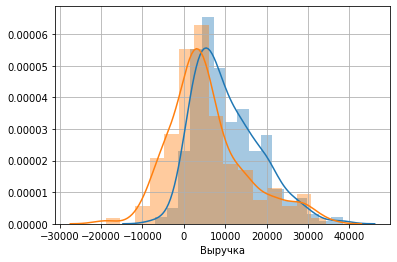

In [42]:
# смотрим распределение
ax = sns.distplot(earn_smart['sum'])
sns.distplot(earn_ultra['sum'])
ax.set_xlabel('Выручка')
plt.grid()

### Проверим гипотезы

- H0: средняя выручка с пользователей тарифа Smart равна средней выручке Ultra
- H1: средняя выручка с пользователей тарифа Smart не равна средней выручки Ultra


In [43]:
# Проверим первое утверждение и гипотезы к нему:
# средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
# H0: средняя выручка с пользователей тарифа Smart равна средней выручке Ultra
# H1: средняя выручка с пользователей тарифа Smart не равна средней выручки Ultra

alpha = 0.05 #критический уровень статистической значимости

results = st.ttest_ind(earn_smart['sum'], earn_ultra['sum'], equal_var = False) # выборки не равны

print('p-значение:', results.pvalue)

    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.061133949510358e-07
Отвергаем нулевую гипотезу


### Вывод

В данном тесте мы используем статистический критерий Стьюдента, потому что как видно из графика, данные распределены нормально. Полученное значение p-value говорит о том, что средняя выручка по Москве и регионам очевидно отличается и получить случайно такой результат представляется невозможным. 

### Проверим утверждение: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Есть возможность проверить это утверждение с разбивкой на тарифы. Можем сравнить выручки по тарифам только по Москве и только по регионам. А так же сравнить выручки по тарифам между регионами и Москвой.

#### Сформулируем нулевую и альтернативную гипотезы для сравнения выручек по тарифам по Москве:
- H0: средняя выручка тарифа Смарт по Москве равна средней выручке тарифа Ультра по Москве,
- H1: средняя выручка тарифа Смарт по Москве не равна средней выручке тарифа Ультра по Москве.

Подготовим данные, сделаем срезы.

In [44]:
# ultra_city_mean = ultra_total_df_grouped.groupby('city')['min_used_rub', 'mess_used_rub', 'gb_used_rub'].mean()
# ultra_city_mean['earn'] = ultra_city_mean['min_used_rub']+ultra_city_mean['mess_used_rub']+ultra_city_mean['gb_used_rub']

# smart_city_mean = smart_total_df_grouped.groupby('city')['min_used_rub', 'mess_used_rub', 'gb_used_rub'].mean()
# smart_city_mean['earn'] = smart_city_mean['min_used_rub']+smart_city_mean['mess_used_rub']+smart_city_mean['gb_used_rub']

moscow_smart_earn = earn_smart.query('city == "Москва"')
moscow_ultra_earn = earn_ultra.query('city == "Москва"')

region_smart_earn = earn_smart.query('city != "Москва"')
region_ultra_earn = earn_ultra.query('city != "Москва"')

moscow_total_earn = moscow_smart_earn.merge(
    moscow_ultra_earn, on=['user_id', 'city', 'min_used_rub', 'mess_used_rub', 'gb_used_rub', 'sum'], how='outer')
region_total_earn = region_smart_earn.merge(
    region_ultra_earn, on=['user_id', 'city', 'min_used_rub', 'mess_used_rub', 'gb_used_rub', 'sum'], how='outer')

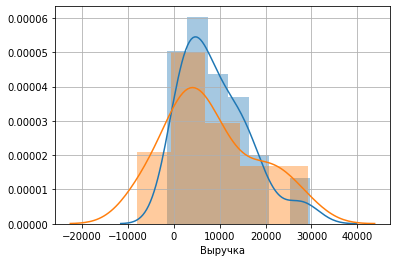

In [45]:
# смотрим распределение
ax = sns.distplot(moscow_smart_earn['sum'])
sns.distplot(moscow_ultra_earn['sum'])
ax.set_xlabel('Выручка')
plt.grid()

#### Проверим гипотезу
- H0: средняя выручка тарифа Смарт по Москве равна средней выручке тарифа Ультра по Москве,
- H1: средняя выручка тарифа Смарт по Москве не равна средней выручке тарифа Ультра по Москве.

In [46]:
# H0: средняя выручка тарифа Смарт по Москве равна средней выручке тарифа Ультра по Москве,
# H1: средняя выручка тарифа Смарт по Москве не равна средней выручке тарифа Ультра по Москве.

# зададим уровень критической статистической значимости
alpha = 0.05

# проверим нулевую гипотезу
results_mos = st.ttest_ind(moscow_smart_earn['sum'], moscow_ultra_earn['sum'])

print("p-значение: ", results_mos.pvalue)


if (results_mos.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.6274093878616391
Не получилось отвергнуть нулевую гипотезу


### Вывод

В данном тесте мы также используем статистический критерий Стьюдента, потому что как видно из графика, данные распределены нормально. Удивительно, но можно утверждать с вероятностью 60%, что средняя выручка по тарифу Смарт равна средней выручке по таифу Ультра по Москве.

#### Проверим гипотезу

- H0: средняя выручка тарифа Смарт по регионам равна средней выручке тарифа Ультра по регионам,
- H1: средняя выручка тарифа Смарт по регионам не равна средней выручке тарифа Ультра по регионам.

In [47]:
# H0: средняя выручка тарифа Смарт по регионам равна средней выручке тарифа Ультра по регионам,
# H1: средняя выручка тарифа Смарт по регионам не равна средней выручке тарифа Ультра по регионам.

# зададим уровень критической статистической значимости
alpha = 0.05

# проверим нулевую гипотезу
results_reg = st.ttest_ind(region_smart_earn['sum'], region_ultra_earn['sum'], equal_var = False)

print("p-значение: ", results_reg.pvalue)


if (results_reg.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  2.9250451876450844e-08
Отвергаем нулевую гипотезу


### Вывод

А вот выручки по регионам с большой вероятностью различны.

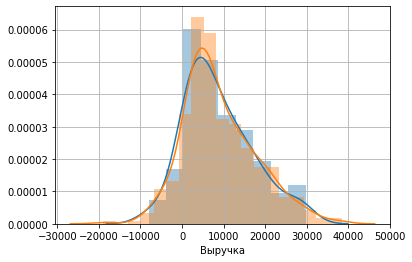

In [48]:
# посмотрим пределение
ax = sns.distplot(moscow_total_earn['sum'])
sns.distplot(region_total_earn['sum'])
ax.set_xlabel('Выручка')
plt.grid()

### Сформулируем нулевую и альтернативную гипотезы:

- H0: средняя выручка по Москве равна средней выручке по регионам,
- H1: средняя выручка по Москве не равна средней выручке по регионам.

In [49]:
# зададим уровень критической статистической значимости
alpha = 0.05

# проверим нулевую гипотезу
results_total = st.ttest_ind(moscow_total_earn['sum'], region_total_earn['sum'], equal_var = False)

print("p-значение: ", results_total.pvalue)


if (results_total.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.8094124910584182
Не получилось отвергнуть нулевую гипотезу


### Вывод

В данном тесте мы снова используем статистический критерий Стьюдента, потому что как видно из графика, данные распределены нормально. Получаем, что средняя выручка по Москве не отличается от средней выручки по регионам. 

In [50]:
# найдём дисперсии
variance_estimate_moscow = np.var(moscow_total_earn['sum'], ddof=1)
variance_estimate_region = np.var(region_total_earn['sum'], ddof=1)
print('Дисперсия по выборке Москва, выручка:', variance_estimate_moscow)
print('Дисперсия по выборке регионы, выручка:', variance_estimate_region)

Дисперсия по выборке Москва, выручка: 68419191.20243248
Дисперсия по выборке регионы, выручка: 76057053.15647157


## Шаг 5. Общие выводы<a id="stepfive"></a>   </div>

Для анализа представлены 5 таблиц с информацией о пльзователях, о двух сравниваемых тарифах, количестве и продолжительности звонков, объёма используемого трафика и количестве сообщений.

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. Это главный вопрос - "больше денег". 

Если посмотреть на срезвы по тарифам, то можно наблюдать, что тарифом Смарт пользуются практически в два раза больше людей чем Ультрой. Видимо отпугивает месячная абонплата в 1950. Это очень любопытно, если посмотреть на графики.

Из гистограммы по месяцам видно, что активность пользователей растёт от месяца к месяцу, в конце года пользователи ведут себя активнее, чем в начале. Так же видим, пользователи тарифа Ультра ведут себя активнее чем люди на Смарте. Показатели среднего звонков, сообщений и трафика подтверждают это:

- Средняя продолжительность звонков. Смарт 384.5502952244915
- Среднее кол-во сообщений. Смарт 31.413210661085547
- Средняя кол-во gb. Смарт 15.223806019421163


- Средняя продолжительность звонков. Ультра 493.1539558972259
- Среднее кол-во сообщений. Ультра 43.71498284147191
- Средняя кол-во gb. Ультра 18.296772400545716


- Дисперсия по выборке smart, минуты разговора: 35847.35040066755
- Дисперсия по выборке smart, смс: 796.8129584480083
- Дисперсия по выборке smart, интернет: 33.16030407078876


- Дисперсия по выборке ultra, минуты разговора: 99756.60867896497
- Дисперсия по выборке ultra, смс: 2285.266142544674
- Дисперсия по выборке ultra, интернет: 97.33494903223144


- Стандартное отклонение по выборке smart, минуты разговора: 189.33396525892428
- Стандартное отклонение по выборке smart, смс: 28.22787555676141
- Стандартное отклонение по выборке smart, интернет: 5.7584984215321935


- Стандартное отклонение по выборке ultra, минуты разговора: 315.84269609880954
- Стандартное отклонение по выборке ultra, смс: 47.80445735017472
- Стандартное отклонение по выборке ultra, интернет: 9.865847608403012


- Дисперсия по выборке Москва, выручка: 68419191.20243248
- Дисперсия по выборке регионы, выручка: 76057053.15647157


Если взглянуть на гистограммы, то заметно, что пользователей тарифа Smart больше, но разговаривают по телефону они меньше чем пользователи тарифа Ultra. На графике видно, что на Смарте чаще перерасходуют лимит включённых минут, в то время как на Ультре 3000 минут более чем для разговоров. Пользователи Ультры не выбирают и половины этого времени. 

Возможно стоит сократить лимит тарифа Ультра до 1000 минут для получения большей выручки. На графике плотности заметно, что пользователям обоих тарифов достаточно 1000-1500 минут в месяц. Интересно, что самый частый показатель продолжительности разговоров на обоих тарифах согласно графикам находится в районе 500 минут.

Любопытно следующее - если перемножить перерасход минут на Смарте - примерно 400-500 минут - и стоимость перерасходованной минуты, то получается пользователи Смарта платят иногда столько же сколько и пользователи Ультры.

Похожая картина и сообщениями. Пользователи Смарта уходят далеко за пределы лимита 50 сообщений в месяц (отпраляют до 100), в то время как на Ультре 1000 сообщений никому не нужны, едва выходят за границы 150. Возможно стоит сократить лимит до 100, и получать чуть больше выручки. На графике плотности видим, что пользователи обоих тарифов удовлетворяются примерно одинаковым количеством сообщений - 80-100. А в месяц отправляют чаще всего 20-40 смс.

И снова если перемножить количество перебранных сообщений по тарифу Смарт - почти треть пользователей перебирают до 50 смс - и рубли за овер лимит, то получим - 150 рублей только на смс переплачивают смартовцы.

По графикам пользования интернетом видно что пользователям Ультры больше нравится пользоваться интернетом. Лимит практически всегда выбирается полностью, но реже превышается. На Смарте охотно пользуются интернетом и почти половина пользователей превышают лимит легко почти в два раза. За что им приходится платить довольно высокую цену.

Глядя на графики можно заметить что чаще всего показатель в 15-20 гб удовлетворяет потребности пользователей.

Графики плотностей показывают, что данные распределены нормално, поэтому можем использовать ttest. Проверим несколько гипотез.

Из формулировки задания понятно что это двухсторонние гипотезы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

Для начала сравним выручки. H-нулевая всегда формулируется так, чтобы использовать знак равенства.

- H0: средняя выручка с пользователей тарифа Smart равна средней выручке Ultra
- H1: средняя выручка с пользователей тарифа Smart не равна средней выручки Ultra

Показатель p-значение говорит о том, что мы не можем принять нулевую гипотезу о равенстве средних выручек тарифов. Если просто посмотреть на средние выручки, то тариф Смарт явно лидирует. Тариф Ультра нуждается в доработке, перспективы у него есть, так как понятно, что пользователи тарифа - это не массовая аудитория.

Далее проверим утверждение: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов
Была возможность проверить это утверждение с разбивкой на тарифы. Можем сравнить выручки по тарифам только по Москве и только по регионам. А так же сравнить выручки по тарифам между регионами и Москвой.

Сформулируем нулевую и альтернативную гипотезы для сравнения выручек по тарифам по Москве:
- H0: средняя выручка тарифа Смарт по Москве равна средней выручке тарифа Ультра по Москве,
- H1: средняя выручка тарифа Смарт по Москве не равна средней выручке тарифа Ультра по Москве.

Удивительно, но можно утверждать с вероятностью 60%, что средняя выручка по тарифу Смарт равна средней выручке по таифу Ультра по Москве. С Ультрой явно нужно то то делать. По Москве из Ультры явно можно выжать больше. Рекламировать этот тариф в нынешнем состоянии явно не стоит.

Далее проверяем выручки с тарифов по регионам.
- H0: средняя выручка тарифа Смарт по регионам равна средней выручке тарифа Ультра по регионам,
- H1: средняя выручка тарифа Смарт по регионам не равна средней выручке тарифа Ультра по регионам.

По Москве средние выручки тарифов равны, а вот по регионам различаются.

И наконец:
- H0: средняя выручка по Москве равна средней выручке по регионам,
- H1: средняя выручка по Москве не равна средней выручке по регионам.

Тут можно говорить о том, что с большой вероятностью можно говорить о том, что средняя выручка по Москве равно средней выручке по регионам. Показатели дисперсий также сопоставимы.

Но, по идее средняя выручка по Москве должна быть выше. И тут нужно работать с тарифом Ультра. Именно за счёт него можно получить ещ больше денег с пользователей, даже не за счёт повышения цен, а за счёт настройки и доработки тарифа. 

- Пользователи тарифа Смарт часто выходят из лимита по минутам разговора, смс и трафику. И часто платят в месяц примерно столько же сколько и пользователи Ультры.
- Пользователи Ультры говорят по телефону дольше, но чаще не выходят за рамки лимита по минутам, зато чаще и больше пользуются интернетом так же почти без перерасхода.
- Тариф Смарт больше ориентирован на массовую аудиторию, поэтому врядли пользователи Смарта будут переходить на тариф Ультра.

На данном этапе тариф Смарт приносит Мегалайну больше денег, а значит этот тариф лучше. Рекламировать целесообразнее тариф Ультра, с него и денег можно больше получить. Но только после тщательной доработки и возможно его стоит активнее продвигать на территории столицы. На Смарт и без рекламы будут приходить пользователи за счёт меньшей видимой абонплаты.